<a href="https://colab.research.google.com/github/MatteoFasulo/Sexism-detection/blob/assignment2/Assignment_2_refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2


**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


## Group

* Luca Babboni - luca.babboni2@studio.unibo.it
* Matteo Fasulo - matteo.fasulo@studio.unibo.it
* Maksim Omelchenko - maksim.omelchenko@studio.unibo.it
* Luca Tedeschini - luca.tedeschini3@studio.unibo.it



## Description

This notebook addresses [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.


## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the binary classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

### Libraries
In order to excecute the code we are gonna install and import the necessary libraries.
First of all we are gonna install the last version of bitsandbytes in order to been able to use the quantization.

In [18]:
%%capture
%pip install -U bitsandbytes

Then we need to reload the notebook kernel

In [ ]:
import os
os.kill(os.getpid(), 9)

Finally we are able to import the required libraries

In [1]:
import pandas as pd
from pathlib import Path
import requests
import os
import re
import random
from copy import deepcopy
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read)

In [ ]:
from kaggle_secrets import UserSecretsClient
secret_label = "hf_key"
secret_value = UserSecretsClient().get_secret(secret_label)

In [ ]:
!huggingface-cli login --token {secret_value}

After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

In [3]:
def download_corpus(url: str, filename: str) -> None:
    """
    Downloads a text corpus from a given URL and saves it to a specified filename within the data folder if not exist

    Args:
        url (str): The URL from which to download the corpus.
        filename (str): The name of the file to save the downloaded corpus.

    Raises:
        requests.exceptions.HTTPError: If the HTTP request returned an unsuccessful status code.

    Side Effects:
        Creates the data folder if it does not exist.
        Writes the downloaded corpus to the specified file.
    """
    data_folder = Path("./data")
    if not data_folder.exists():
      data_folder.mkdir(parents=True)
      print(f"Created folder {data_folder}.")

    if not (data_folder / filename).exists():
      response = requests.get(url)
      response.raise_for_status()
      with open(data_folder / filename, 'w', encoding='utf-8') as f:
        f.write(response.text)
      print(f"Created file {data_folder / filename}.")
    else:
      print(f"File {data_folder / filename} already exists.")

In [4]:
path_test = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/a2_test.csv'
path_demonstrations = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/demonstrations.csv'

In [5]:
download_corpus(path_test, 'a2_test.csv')
download_corpus(path_demonstrations, 'demonstrations.csv')

File data/a2_test.csv already exists.
File data/demonstrations.csv already exists.


In [6]:
df = pd.read_csv('./data/a2_test.csv', encoding='utf-8')
df.head()

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,not sexist
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,sexist
2,sexism2022_english-3018,Old man mogs everyone in this sub,not sexist
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",not sexist
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,sexist


# Mistral V3 instruct in 8bit
As first model we are gonna analyze the performance of Mistral V3

## Task 1 - Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware


In [7]:
def load_model(model_card):
    """
    Loads a pre-trained model and its tokenizer with 8-bit quantization.

    Args:
        model_card (str): The identifier of the pre-trained model to load.

    Returns:
        tuple: A tuple containing the quantized model and the tokenizer.
            - model_8bit (transformers.PreTrainedModel): The quantized model loaded in 8-bit precision.
            - tokenizer (transformers.PreTrainedTokenizer): The tokenizer associated with the model.
    """
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    tokenizer = AutoTokenizer.from_pretrained(model_card)
    model_8bit = AutoModelForCausalLM.from_pretrained(model_card, quantization_config=quantization_config)
    model_8bit.eval()
    return model_8bit, tokenizer

In [8]:
model_card = 'mistralai/Mistral-7B-Instruct-v0.3'
model_8bit, tokenizer = load_model(model_card)

device = model_8bit.device
print(f'Model loaded on {device}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model loaded on cuda:0


## Task 2 - Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


### Prompt Template

Use the following prompt template to process input texts.

In [9]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

### Instructions

In order to get Task 2 points, we require you to:

* Write the ``prepare_prompts`` function

In [10]:
def prepare_prompts(texts, prompt_template, tokenizer, device):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """
  prompts = []
  for text in texts:
    prompt_with_text = deepcopy(prompt_template)
    # add text
    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)

    prompts.append(tokenizer.apply_chat_template(prompt_with_text, tokenize=True,
                                                 add_generation_prompt=True,
                                                 return_dict=True,
                                                 return_tensors="pt").to(device))

  return prompts

In [11]:
prompts = prepare_prompts(df['text'], prompt, tokenizer, device=device)

print("Prompt example: \n")
print(tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True))

Prompt example: 

You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        


## Task 3 - Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [12]:
def generate_responses(model, prompt_examples):
  """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples

    Outputs:
      generated responses
  """
  answers = []
  for prompt in tqdm(prompt_examples):
    response = model.generate(**prompt, max_new_tokens=1000, pad_token_id=tokenizer.eos_token_id)
    answers.append(response)
  return answers

In [13]:
def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed binary response: return 1 if YES and 0 if NO
  """
  response = tokenizer.decode(response[0])
  if 'YES' in response.split('ANSWER')[-1]:
    return 1
  else:
    return 0

In [14]:
def get_generated_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to extract only the text generated by the LLM.

    Inputs:
      response: generated response from LLM

    Outputs:
      LLM generated text: string
  """
  response = tokenizer.decode(response[0])
  response = response.split('[/INST]')[-1]
  cleaned_string = re.sub(r'</s>', '', response).strip()
  return cleaned_string

In [15]:
answers = generate_responses(model_8bit, prompts)

100%|██████████| 300/300 [03:59<00:00,  1.25it/s]


In [16]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

In [17]:
original_labels = [1 if label == 'sexist' else 0 for label in df['label_sexist']]

In [18]:
models_predictions = pd.DataFrame({
    'text': df['text'],
    'original_labels': original_labels,
    'mistralv3_zero_shot_labels': batch_predictions,
    'mistralv3_zero_shot_answers': generated_answers
})

## Task 4 - Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

### Instructions

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [19]:
def compute_metrics(responses, y_true):
  """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function compute accuracy and fail-ratio metrics.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
      responses: generated LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics
  """
  y_pred = [process_response(response) for response in responses]
  accuracy = (np.array(y_pred) == np.array(y_true)).mean()
  fail_ratio = (np.array(y_pred) != np.array(y_true)).mean()
  return {'accuracy': accuracy, 'fail_ratio': fail_ratio}

In [20]:
mistal_base_metrics = compute_metrics(answers, original_labels)

In [21]:
for key, value in mistal_base_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.61
fail_ratio: 0.39


In [22]:
#create the new dataset for storing the metrics
model_metrics = pd.DataFrame(columns=['model', 'accuracy', 'fail_ratio'])
#add the computed metrics to the metric dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 zero shot', 'accuracy': mistal_base_metrics['accuracy'], 'fail_ratio': mistal_base_metrics['fail_ratio']}

## Task 5 - Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [23]:
prompt_few_shot = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

```
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: **example 1**
        ANSWER: YES
        TEXT: **example 2**
        ANSWER: NO

        TEXT:
        {text}

        ANSWER:
        """
    }
]
```  

## Instructions

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

In [24]:
demonstrations = pd.read_csv('./data/demonstrations.csv')
demonstrations.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


In [25]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2):
  """
    Inputs:
      demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
      num_per_class: number of demonstrations per class

    Outputs:
      a list of textual demonstrations to inject into the prompt template.
  """
  yes_samples = demonstrations[demonstrations['label_sexist'] == 'sexist'].sample(num_per_class)
  no_samples = demonstrations[demonstrations['label_sexist'] == 'not sexist'].sample(num_per_class)

  few_shot_demonstrations = list(pd.concat([yes_samples['text'], no_samples['text']]))

  return few_shot_demonstrations

In [26]:
build_few_shot_demonstrations(demonstrations, num_per_class=2)

['PhD’s in thotism',
 'No divorced woman is family oriented.',
 "that Yvette Felarca needs to get fired as a schoolteacher so that she can feel MORE MARTYRED and LESS-PENSIONED...it'll be great for her delusions of glory [URL]",
 "So many defending why that's the case. Saying that there's more adjectives to describe women over all? That's so ridiculous."]

In [27]:
def prepare_prompts_few_shot(texts, demonstrations, prompt_template, tokenizer, device):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """
  prompts = []
  for text in texts:
    prompt_with_text = deepcopy(prompt_template)
    demonstration = ''
    for i, d in enumerate(demonstrations):
      if i < len(demonstrations) // 2:
        demonstration += '\tTEXT: ' + d + '\n\tANSWER: YES\n'
      else:
        demonstration += '\tTEXT: ' + d + '\n\tANSWER: NO\n'

    # remove extra \t
    demonstration = demonstration[1:]
    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{examples}', demonstration)

    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)
    prompts.append(tokenizer.apply_chat_template(prompt_with_text, tokenize=True, add_generation_prompt=True,
              return_dict=True,
              return_tensors="pt").to(device))

  return prompts

### 2-shot learning

In [28]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=1), prompt_few_shot, tokenizer, device=device)

In [29]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Did she get his consent in writing? Maybe she raped him.
	ANSWER: YES
	TEXT: Help Refugees wants to help women and children in Calais! They just need, uh, more men’s shoes, men’s coats, men’s shirts, and men’s underwear. But don’t ask why, ok? [URL]
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


In [30]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [07:51<00:00,  1.57s/it]


In [31]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]
models_predictions['mistralv3_2_shot_labels'] = batch_predictions
models_predictions['mistralv3_2_shot_answers'] = generated_answers

In [32]:
#compute the metrics
mistalv3_2_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 2 shot', 'accuracy': mistalv3_2_shot_metrics['accuracy'], 'fail_ratio': mistalv3_2_shot_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_2_shot_metrics.items():
  print(f'{key}: {value:.2f}')


accuracy: 0.61
fail_ratio: 0.39


### 4-shot leaning

In [33]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=2), prompt_few_shot, tokenizer, device=device)

In [34]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Occasionally, without me knowing it, my wife's vagina will reset itself from the original factory settings to 'Challenge Mode.'
	ANSWER: YES
	TEXT: Rule number 1, never take a woman out and expect anything in return. You'll be lucky to even get a mention on her snapchat or her tweet or whatever. That's the most you can hope for when you take bitches out to eat.
	ANSWER: YES
	TEXT: I dont understand when people see a mixed raced couple and say "it is ok, she ugly and fat". All white women must be protected. [URL]
	ANSWER: NO
	TEXT: I meant what that soapboxing thing is
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


In [35]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [06:57<00:00,  1.39s/it]


In [36]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]
models_predictions['mistralv3_4_shot_labels'] = batch_predictions
models_predictions['mistralv3_4_shot_answers'] = generated_answers

In [37]:
#compute the metrics
mistalv3_4_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 4 shot', 'accuracy': mistalv3_4_shot_metrics['accuracy'], 'fail_ratio': mistalv3_4_shot_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_4_shot_metrics.items():
  print(f'{key}: {value:.2f}')


accuracy: 0.66
fail_ratio: 0.34


### 8-shot leaning

In [38]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=4), prompt, tokenizer, device=device)

In [39]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


In [40]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [04:01<00:00,  1.24it/s]


In [41]:
#compute the metrics
mistalv3_8_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 8 shot', 'accuracy': mistalv3_8_shot_metrics['accuracy'], 'fail_ratio': mistalv3_8_shot_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_8_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.61
fail_ratio: 0.39


In [42]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['mistralv3_8_shot_labels'] = batch_predictions
models_predictions['mistralv3_8_shot_answers'] = generated_answers

In [44]:
model_metrics

,model,accuracy,fail_ratio
0,Mistral v3 zero shot,0.613333,0.386667
1,Mistral v3 2 shot,0.606667,0.393333
2,Mistral v3 4 shot,0.656667,0.343333
3,Mistral v3 8 shot,0.613333,0.386667


# Llama 2 8B

## Task 1 - Model setup

In [46]:
del model_8bit

NameError: name 'model_8bit' is not defined

In [49]:
import gc

torch.cuda.empty_cache()

with torch.no_grad():
  torch.cuda.empty_cache()

gc.collect()

230

In [50]:
model_card = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model_8bit, tokenizer = load_model(model_card)

device = model_8bit.device
print(f'Model loaded on {device}')

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Model loaded on cuda:0


## Task 2 - Prompt setup

In [51]:
prompts = prepare_prompts(df['text'], prompt, tokenizer, device=device)

print("Prompt example: \n")
print(tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True))

Prompt example: 

system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.user

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:assistant




## Task 3 - Inference


In [52]:
def get_generated_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to extract only the text generated by the LLM.

    Inputs:
      response: generated response from LLM

    Outputs:
      LLM generated text: string
  """
  response = tokenizer.decode(response[0])
  response = response.split('<|end_header_id|>')[-1]
  response = re.sub(r'</s>', '', response).strip()
  response = re.sub(r'<\|eot_id\|>', '', response).strip()
  return response

In [53]:
answers = generate_responses(model_8bit, prompts)

100%|██████████| 300/300 [01:35<00:00,  3.16it/s]


In [54]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

In [55]:
models_predictions['llama3_zero_shot_labels'] = batch_predictions
models_predictions['llama3_zero_shot_answers'] = generated_answers

## Task 4 - Metrics

In [57]:
#compute the metrics
llama3_base_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 zero shot', 'accuracy': llama3_base_metrics['accuracy'], 'fail_ratio': llama3_base_metrics['fail_ratio']}

#print the metrics
for key, value in llama3_base_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.64
fail_ratio: 0.36


## Task 5 - Few-shot Inference

### 2-shot learning

In [58]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=1), prompt_few_shot, tokenizer, device=device)

In [59]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: It's a sad day for men when a once virile, gold-medal American olympic champion decides he'd rather be female..TRP is more important now than ever....
	ANSWER: YES
	TEXT: Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [60]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [01:50<00:00,  2.72it/s]


In [61]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_2_shot_labels'] = batch_predictions
models_predictions['llama3_2_shot_answers'] = generated_answers

In [62]:
#compute metrics
llama3_2_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 2 shot', 'accuracy': llama3_2_shot_metrics['accuracy'], 'fail_ratio': llama3_2_shot_metrics['fail_ratio']}

#print the metrics
for key, value in llama3_2_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.64
fail_ratio: 0.36


### 4-shot leaning

In [63]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=2), prompt_few_shot, tokenizer, device=device)

In [64]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: As long as the women vote, the majority of them will never miss a chance to vote themselves a good chunk of public funds and push for the preferential treatment under the law. So yes, they are the enemies no matter how you slice it.
	ANSWER: YES
	TEXT: Don't know but what I do know is that there will be an army of dykes waiting for them.....with broom handles
	ANSWER: YES
	TEXT: Methinks those other women like the idea of getting off a ship first better than being treated like an adult.
	ANSWER: NO
	TEXT: Hate fucking is a real thing so I’m sorry but I’m really not buying that most men need affection or any sort of fondness to have sex. If they find th

In [65]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [02:01<00:00,  2.47it/s]


In [66]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_4_shot_labels'] = batch_predictions
models_predictions['llama3_4_shot_answers'] = generated_answers

In [67]:
#compute metrics
llama3_4_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'llama3 4 shot', 'accuracy': llama3_4_shot_metrics['accuracy'], 'fail_ratio': llama3_4_shot_metrics['fail_ratio']}

#print the metrics
for key, value in llama3_4_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.69
fail_ratio: 0.31


### 8-shot leaning

In [68]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=4), prompt, tokenizer, device=device)

In [69]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [70]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [01:33<00:00,  3.21it/s]


In [71]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_8_shot_labels'] = batch_predictions
models_predictions['llama3_8_shot_answers'] = generated_answers

In [72]:
#compute metrics
llama3_8_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 8 shot', 'accuracy': llama3_8_shot_metrics['accuracy'], 'fail_ratio': llama3_8_shot_metrics['fail_ratio']}

for key, value in llama3_8_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.64
fail_ratio: 0.36


In [73]:
models_predictions.head()

,text,original_labels,mistralv3_zero_shot_labels,mistralv3_zero_shot_answers,mistralv3_2_shot_labels,mistralv3_2_shot_answers,mistralv3_4_shot_labels,mistralv3_4_shot_answers,mistralv3_8_shot_labels,mistralv3_8_shot_answers,llama3_zero_shot_labels,llama3_zero_shot_answers,llama3_2_shot_labels,llama3_2_shot_answers,llama3_4_shot_labels,llama3_4_shot_answers,llama3_8_shot_labels,llama3_8_shot_answers
0,The boys must be gaming because there goes the...,0,1,YES,1,YES,1,YES,1,YES,0,NO,0,NO,0,NO,0,NO
1,Look at those eyes. Either someone unexpectedl...,1,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES
2,Old man mogs everyone in this sub,0,0,NO,0,NO (The text does not contain sexism as it is ...,0,NO,0,NO,1,YES,1,YES,1,YES,0,NO
3,"Excellent, I was just looking at another post ...",0,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES
4,So you run back to daddy whenever you need hel...,1,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES


In [74]:
models_predictions.to_csv('models_predictions.csv', index=False)

In [75]:
model_metrics.to_csv('model_metrics.csv', index=False)

In [76]:
models_predictions

,text,original_labels,mistralv3_zero_shot_labels,mistralv3_zero_shot_answers,mistralv3_2_shot_labels,mistralv3_2_shot_answers,mistralv3_4_shot_labels,mistralv3_4_shot_answers,mistralv3_8_shot_labels,mistralv3_8_shot_answers,llama3_zero_shot_labels,llama3_zero_shot_answers,llama3_2_shot_labels,llama3_2_shot_answers,llama3_4_shot_labels,llama3_4_shot_answers,llama3_8_shot_labels,llama3_8_shot_answers
0,The boys must be gaming because there goes the...,0,1,YES,1,YES,1,YES,1,YES,0,NO,0,NO,0,NO,0,NO
1,Look at those eyes. Either someone unexpectedl...,1,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES
2,Old man mogs everyone in this sub,0,0,NO,0,NO (The text does not contain sexism as it is ...,0,NO,0,NO,1,YES,1,YES,1,YES,0,NO
3,"Excellent, I was just looking at another post ...",0,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES
4,So you run back to daddy whenever you need hel...,1,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,It stops white women from being hit (or worse)...,0,1,YES,1,YES,1,YES,1,YES,0,NO,1,YES,1,YES,0,NO
296,Alexa Chung Her father is 3/4 Chinese if that ...,0,1,YES,0,NO,0,NO,1,YES,0,NO,1,YES,1,YES,0,NO
297,Chelsea Clinton leaned over to her husband and...,0,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES
298,"Thats because all women are different, but all...",0,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES,1,YES


In [77]:
model_metrics

,model,accuracy,fail_ratio
0,Mistral v3 zero shot,0.613333,0.386667
1,Mistral v3 2 shot,0.606667,0.393333
2,Mistral v3 4 shot,0.656667,0.343333
3,Mistral v3 8 shot,0.613333,0.386667
4,Llama3 zero shot,0.643333,0.356667
5,Llama3 zero shot,0.643333,0.356667
6,Llama3 2 shot,0.636667,0.363333
7,llama3 4 shot,0.693333,0.306667
8,Llama3 8 shot,0.640000,0.360000


# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

### Instructions

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

### Performance evaluation

In order to being able to analyze all the answer given by the LLMs without re running all the answer evaluation we saved all the data inside the `models_predictions.csv` dataset, that can be easily imported using pandas.


We are gonna then proceed doing some evaluation of the model, and show what are the most common error and which model is the best performing one  

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [3]:
model_metrics = pd.read_csv('model_metrics.csv', index_col='model')

In [4]:
#Sort the dataframe by accuracy in descending order
model_metrics_sorted = model_metrics.sort_values('accuracy', ascending=False)

# Display the sorted scores
model_metrics_sorted

,accuracy,fail_ratio
model,,
llama3 4 shot,0.693333,0.306667
Mistral v3 4 shot,0.656667,0.343333
Llama3 zero shot,0.643333,0.356667
Llama3 zero shot,0.643333,0.356667
Llama3 8 shot,0.640000,0.360000
Llama3 2 shot,0.636667,0.363333
Mistral v3 zero shot,0.613333,0.386667
Mistral v3 8 shot,0.613333,0.386667
Mistral v3 2 shot,0.606667,0.393333


When comparing **Mistral v3 4-shot** with the **Mistral v3 zero shot** (base-model), there is a significant difference in performance. The Mistral model promped with a 4 shot technique scored an accuracy of 0.75, while the Mistral v3 model promped with a zero-shot technique scored 0.613. This substantial improvement can be attributed to the additional context provided by the four examples, which enhances the model's predictive accuracy. In contrast, the zero-shot model relies solely on its pre-trained knowledge without specific examples to guide its predictions, resulting in lower performance.

However, increasing the number of examples in the prompt beyond a certain point can significantly decrease the model's performance. This decline can be due to several factors, such as context overload where the model struggles to process too much information, and the introduction of noise and variability from additional examples. These factors can overwhelm the model, reducing its ability to generalize and make accurate predictions.

From this empiric expents we shown that  while some additional context is beneficial, too many examples can be detrimental to the model's performance.


### Error analysis

In [5]:
models_predictions = pd.read_csv('models_predictions.csv')

Visualizing the confusion matrix is crucial because it provides detailed insights into the types of errors the model makes, such as false positives and false negatives. This allows for a more comprehensive evaluation of the model's performance beyond a single accuracy metric, highlighting areas for improvement. Additionally, it helps in understanding the model's behavior in different classes, which is essential for developing robust and reliable models.

In [7]:
def print_models_confusion_matrixs(models_list, models_predictions):

  fig, axes = plt.subplots(1, len(models_list), figsize=(30, 5))

  actual = models_predictions['original_labels']

  for i, model in enumerate(models_list):

    predicted = models_predictions[model]
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["not sexist", "sexist"])

    cm_display.plot(ax=axes[i])
    axes[i].set_title(model)

  plt.show()

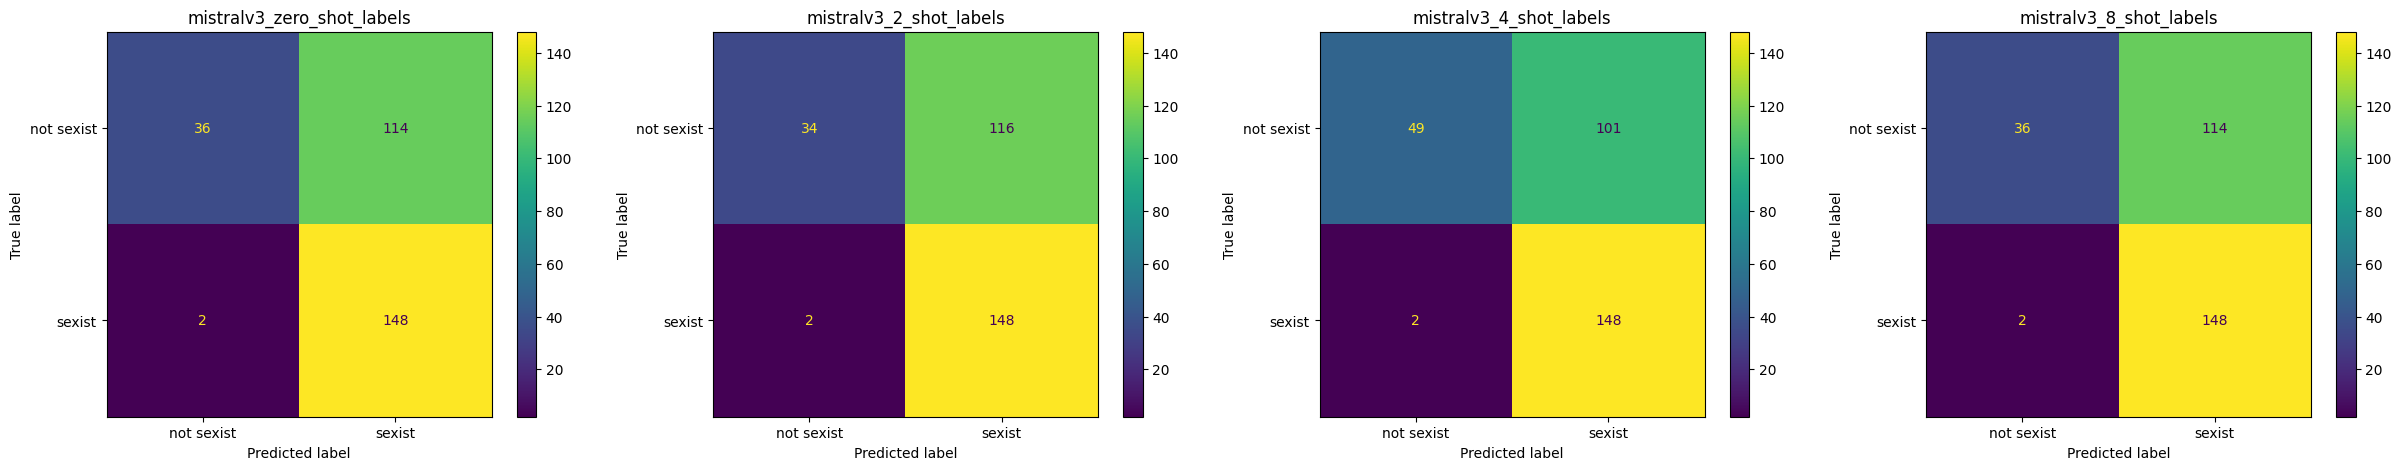

In [26]:
mistral_models_labels = ['mistralv3_zero_shot_labels', 'mistralv3_2_shot_labels', 'mistralv3_4_shot_labels', 'mistralv3_8_shot_labels']
print_models_confusion_matrixs(mistral_models_labels, models_predictions)

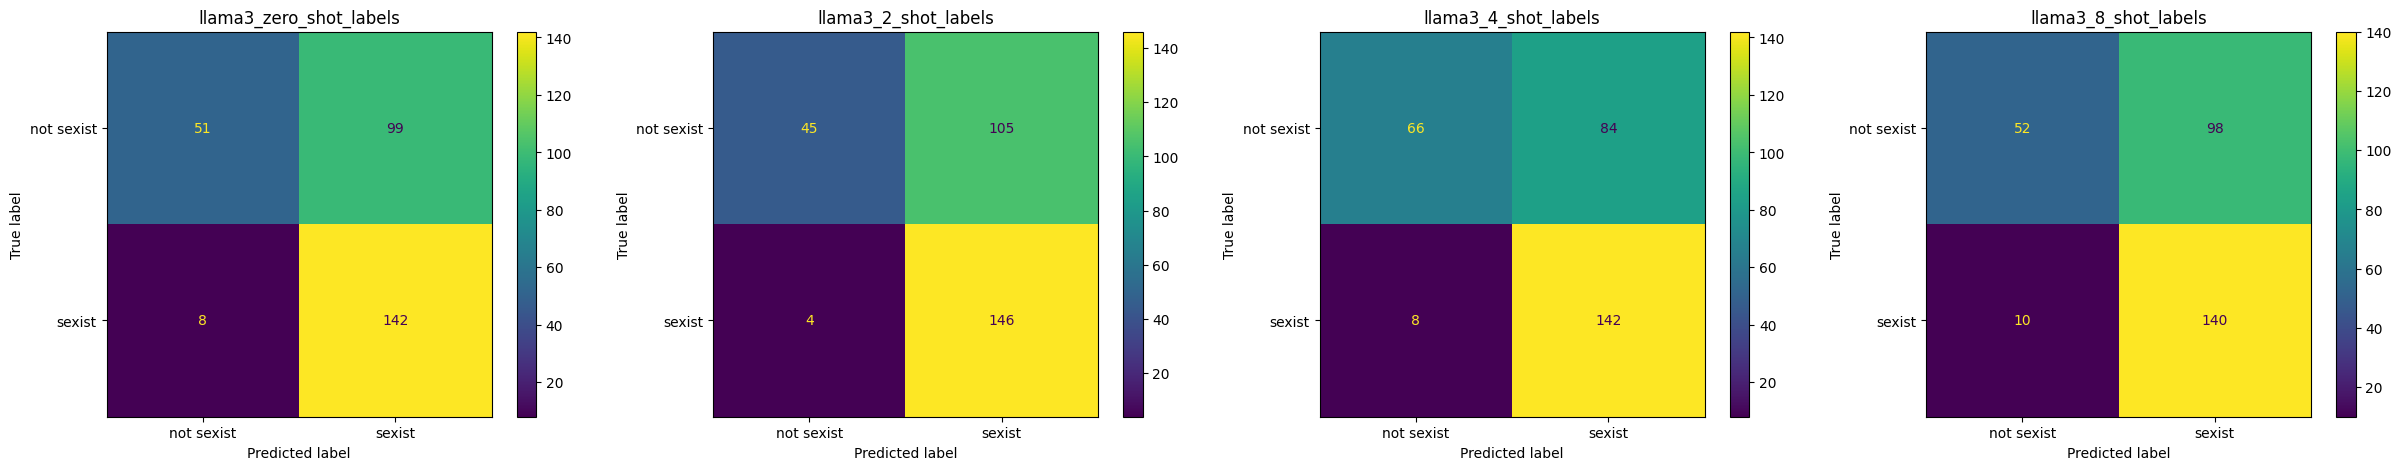

In [27]:
llama_models_labels = ['llama3_zero_shot_labels', 'llama3_2_shot_labels', 'llama3_4_shot_labels', 'llama3_8_shot_labels']
print_models_confusion_matrixs(llama_models_labels, models_predictions)

In all the confusion matrix that concern the mistral model we see that only 2 phrases are uncorrectly classified as not sexist while labeled as sexist.

In [40]:
def print_misslabeled_tweets(model_name, model_list, misslabel_type="fp", text_limit=10):
  if misslabel_type == 'fp':
    print(f"Not sexist labeled tweet classified as sexist by {model_name}")
    flag = 0
  elif misslabel_type == 'fn':
    print(f"Sexist labeled tweet classified as not sexist by {model_name}")
    flag = 1
  else:
    print(f"ERROR, misslabel_type must be set to 'fp'or 'fn'")
    return

  for model in model_list:
    miss_labeled = models_predictions[models_predictions['original_labels'] != models_predictions[model]]
    filtered_df = miss_labeled[miss_labeled['original_labels'] == flag]

    print(f"\nAnalyzing {model}:")
    for i, (row_index, row) in enumerate(filtered_df.iterrows()):
      print(f"row {row_index}) {row['text']} ")
      if i >= text_limit:
        break

#### False Negative

In [41]:
print_misslabeled_tweets('Mistralv3', mistral_models_labels, misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Mistralv3

Analyzing mistralv3_zero_shot_labels:
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 140) Karma's a bitch! 

Analyzing mistralv3_2_shot_labels:
row 140) Karma's a bitch! 
row 170) Half the human population counts as a 'minority' to you? Some women don't give a shit about pushing paper as an office drone for 50 years of their life. 

Analyzing mistralv3_4_shot_labels:
row 140) Karma's a bitch! 
row 245) To female Bishops stop making fun of religion. 

Analyzing mistralv3_8_shot_labels:
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 140) Karma's a bitch! 


In [43]:
print_misslabeled_tweets('Llama3', llama_models_labels, misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Llama3

Analyzing llama3_zero_shot_labels:
row 16) Giving women all your money is good personality. 
row 40) How do you make Lady Gaga scream? Bite her clit off. 
row 59) Greens, eh? The fateful question of the Occident is thus now whether young female university graduates can be continually served with yoga and Pilates courses even amidst the ruins looming on the horizon. 
row 142) What's the going timeframe onto getting on GAB nowadays??? I'm trying to recruit hardcore since twat is going crazy with censorship. 
row 220) what have you tried already? I like to point out that nobody blinks when a smaller man starts shit with a larger man and gets his ass beat, men and women are equal right? 
row 238) Not all Blacks are complete NIGGERS like this whore The Pure POS Nigger bitch gives others a bad name fucking cunt Should investigate where she worked and deaths 
row 245) To female Bishops stop making fun of religion. 
row 249) I know mine 

#### False positive

It is clear that the 2 tweets that are

In [44]:
print_misslabeled_tweets('Mistralv3', mistral_models_labels, misslabel_type="fp", text_limit=10)

Not sexist labeled tweet classified as sexist by Mistralv3

Analyzing mistralv3_zero_shot_labels:
row 0) The boys must be gaming because there goes the wifi. 
row 3) Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior. 
row 6) ‪Import the third world and become the third world. You won’t see feminists protesting about this. ‬ ‪[URL] 
row 10) The black African will soon be labeling her a racist. Race card coming soon 
row 15) I saw this from [USER] herself but I thought I would share [USER] 's video on it. Keep up the good work on #PizzaGate guys! This is real #News. Don't be afraid to #SpeakFreely. [URL] 
row 17) Na he's not flirting with her so she's reading him as gay. 
row 26) Good - the grid girls can finally get back into F1 
row 27) #Italy: #Muslim #migrant gropes American student’s girlfriend, then #stabs the student twice: [URL] 
row 32) Before I decided to

In [45]:
print_misslabeled_tweets('Llama3', llama_models_labels, misslabel_type="fp", text_limit=10)

Not sexist labeled tweet classified as sexist by Llama3

Analyzing llama3_zero_shot_labels:
row 2) Old man mogs everyone in this sub 
row 3) Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior. 
row 6) ‪Import the third world and become the third world. You won’t see feminists protesting about this. ‬ ‪[URL] 
row 7) Most women find a highly educated and well traveled man sexy. 
row 10) The black African will soon be labeling her a racist. Race card coming soon 
row 26) Good - the grid girls can finally get back into F1 
row 27) #Italy: #Muslim #migrant gropes American student’s girlfriend, then #stabs the student twice: [URL] 
row 34) I'm his first ever girlfriend Incels do not get girlfriends ever 
row 38) Yes, let's all be LECTURED by a Jack-ass like this Jimbo Bono's Bud in Red #BoycottedOscars #BoycottHollywood 
row 39) Sick fucks....santanic people need to bur

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End